# Основные концепции Machine Learning. Домашняя работа

In [1]:
### Тут нужно сделать импорты всех необходимых библиотек ###

In [2]:
import pandas as pd
import numpy as np
import sklearn

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from pandas.plotting import andrews_curves

from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import f1_score
from yellowbrick.classifier import ClassificationReport

%matplotlib inline



In [3]:
### Здесь требуется загрузить датасет phones.csv ###

In [4]:
df = pd.read_csv('1.8_phones.csv')

In [5]:
### Опционально: используя matplotlib, можно сделать визуализацию загруженного датасета ###

Исходя из гистограммы - большинство телефонов марки Android. Это же подтверждается группировкой и подсчётом значений.

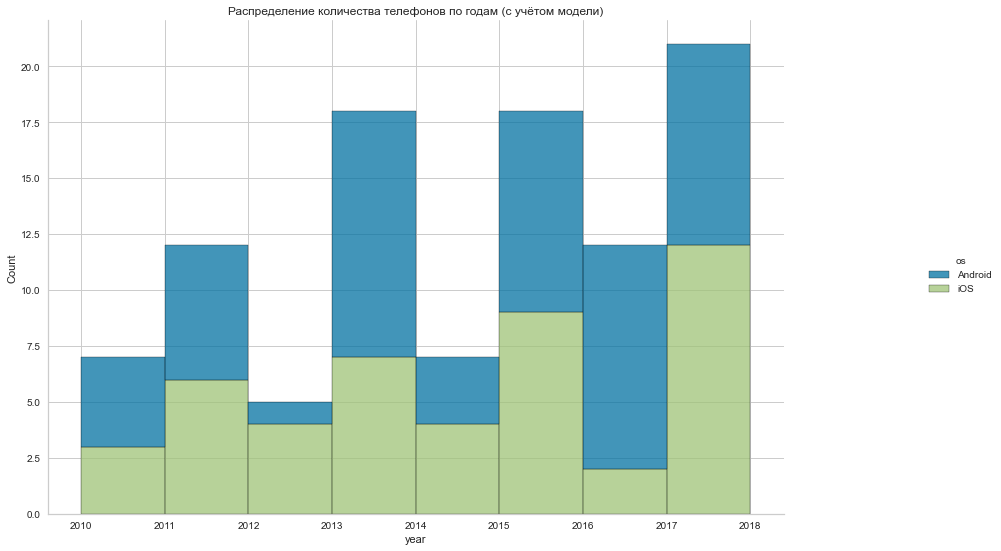

In [6]:
sns.displot(df, 
            x="year",
            hue="os", 
            multiple="stack").set(title='Распределение количества телефонов по годам (с учётом модели)')
plt.gcf().set_size_inches(15, 8)

In [7]:
df.groupby(by='os')[['os']].count()

,os
os,
Android,53
iOS,47


Распределение моделей телефонов по стоимости показывает чёткое разделение на ценовые кластеры, где айфоны в основном идут в верхней ценовой категории, а андроиды в нижней и средней.

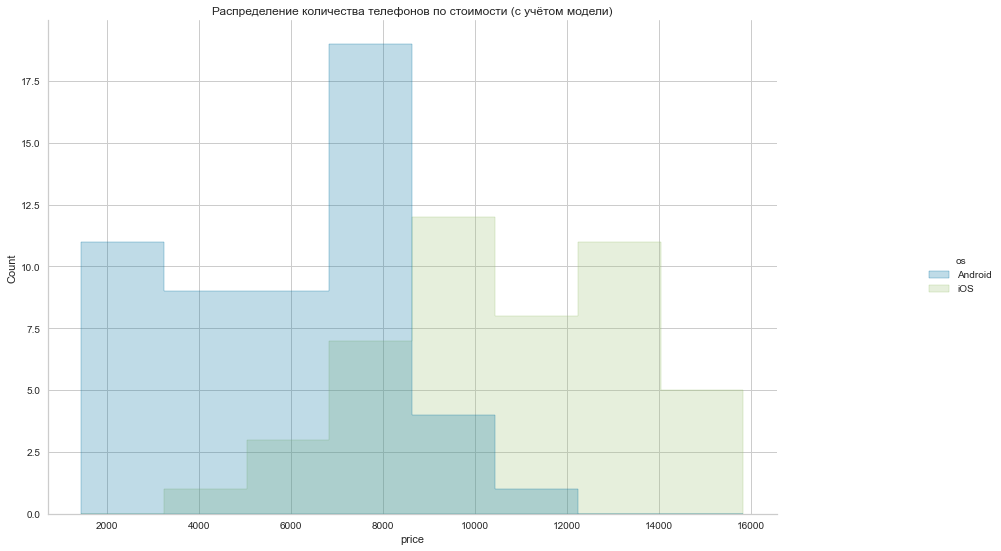

In [8]:
sns.displot(df, 
            x="price",
            hue="os", 
            element="step").set(title='Распределение количества телефонов по стоимости (с учётом модели)')
plt.gcf().set_size_inches(15, 8)

Распределение же по объёму дискового пространства показывает однозначное разделение на два кластера. 

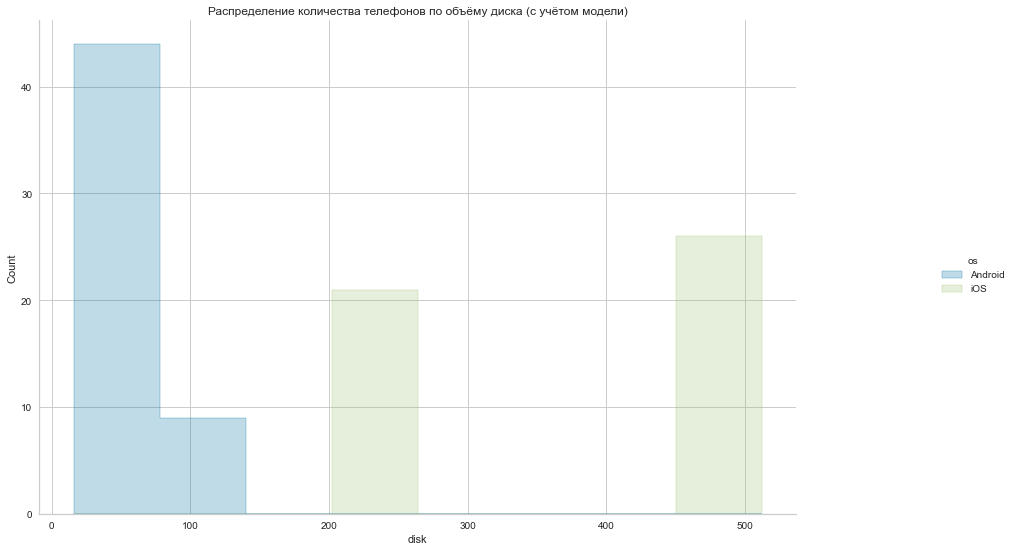

In [9]:
sns.displot(df, 
            x="disk",
            hue="os", 
            element="step").set(title='Распределение количества телефонов по объёму диска (с учётом модели)')
plt.gcf().set_size_inches(15, 8)

Задание 1: обучить модель регрессии. Закодируем название операционной системы через OneHotEncoding (т.к. невозможно проранжировать в порядке возрастания модели ОС). Для сопоставления закодируем операционную систему и с использованием LabelEncoder в том числе.

In [10]:
### Тут нужно выгрузить в соответствующие переменные выбранные признаки ###
onehot_encoder = OneHotEncoder(sparse=False)
le = LabelEncoder()

encoded_os = pd.DataFrame(onehot_encoder.fit_transform(df['os'].values.reshape(-1,1)), columns=onehot_encoder.categories_)
df_hot = df.join(encoded_os).copy(deep=True)

le.fit(df['os'])
df_le = df.copy(deep=True)
df_le['os'] = le.transform(df_le['os'])

Проверим корреляцию новых переменных с целевой, также построим таблицу корреляции для label-кодирования признака 'os'. Как видно из сравнения OneHot-переменные значительно лучше связаны с целевой переменной чем закодированная переменная os с использованием LabelEncoder.

<AxesSubplot:>

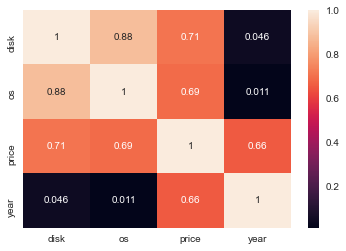

In [11]:
sns.heatmap(df_le.corr().apply(abs), annot = True)

<AxesSubplot:>

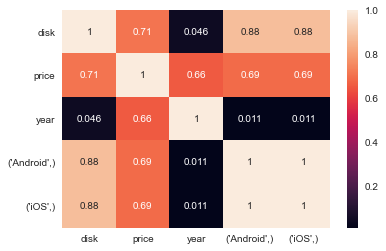

In [12]:
sns.heatmap(df_hot.corr().apply(abs), annot = True)

Разделим датасет на выборку признаков и целевой переменной, а также уменьшим размерность признака года выпуска.

In [13]:
X = df_hot.drop(['price', 'os'], axis=1)
X['year'] = X['year'] - 2000
y = df_hot['price']

Воспользуемся моделью решающего дерева. Сперва воспользуемся кросс-валидацией для проверки общего качества модели. Наша модель в основном занижает прогноз в среднем на 462 у.е.

In [14]:
### Здесь следует запустить процесс обучения ###
### и продемонстрировать работоспобность обученной модели ###
regr = DecisionTreeRegressor(random_state=42)
cross_val_score(regr, X, y, cv=10, scoring='neg_mean_absolute_error').mean()


-462.04049999999995

Обучим модель и построим графики. Итоговая метрика качества практически совпала с метрикой, полученной на кросс-валидации и модель действительно преимущественно занижает прогноз.

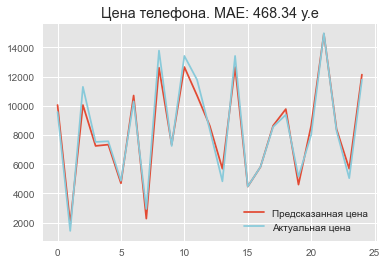

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
regr = regr.fit(X_train,y_train)
y_pred = regr.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)

with plt.style.context('ggplot'):    
    plt.plot(y_pred, label='Предсказанная цена')
    plt.plot(y_test.values, "c", label = 'Актуальная цена')
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title(f"Цена телефона. MAE: {round(mae, 2)} у.е")
    plt.grid(True)

Задание 2: обучить модель классификации

In [16]:
X = df_hot.drop(['os', ('Android',), ('iOS',)], axis=1)
X['year'] = X['year'] - 2000
y = df_le[['os']]

In [17]:
clf = DecisionTreeClassifier(random_state=42)
cross_val_score(clf, X, y, cv=10, scoring='f1')

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

F1-мера равна единице, причём данная картина характерна для любого распределения выборки. Причина проста - модель телефона определяется однозначным условием по размеру дискового пространства. И мы можем увидеть это на графе нашего дерева.

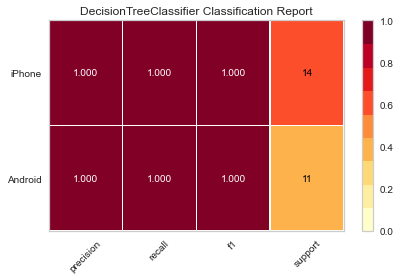

In [18]:
### Здесь следует запустить процесс обучения ###
### и продемонстрировать работоспобность обученной модели ###
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

visualizer = ClassificationReport(clf, classes=['Android', 'iPhone'], support=True)
visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()     

tree.export_graphviz(clf,
                     out_file="tree.dot",
                     feature_names = X.columns, 
                     class_names=['Android', 'iOS'],
                     filled = True)

<img src="tree.png">

Задание 3: обучить модель кластеризации

Предварительно проведём небольшой анализ, позволяющий нам сделать предположение по наличию кластеров. В качестве метки воспользуемся операционной системой. Исходя матрицы рассеяния, кривых Эндрюса и параллельных координат у нас действительно есть чётко выраженные кластеры.

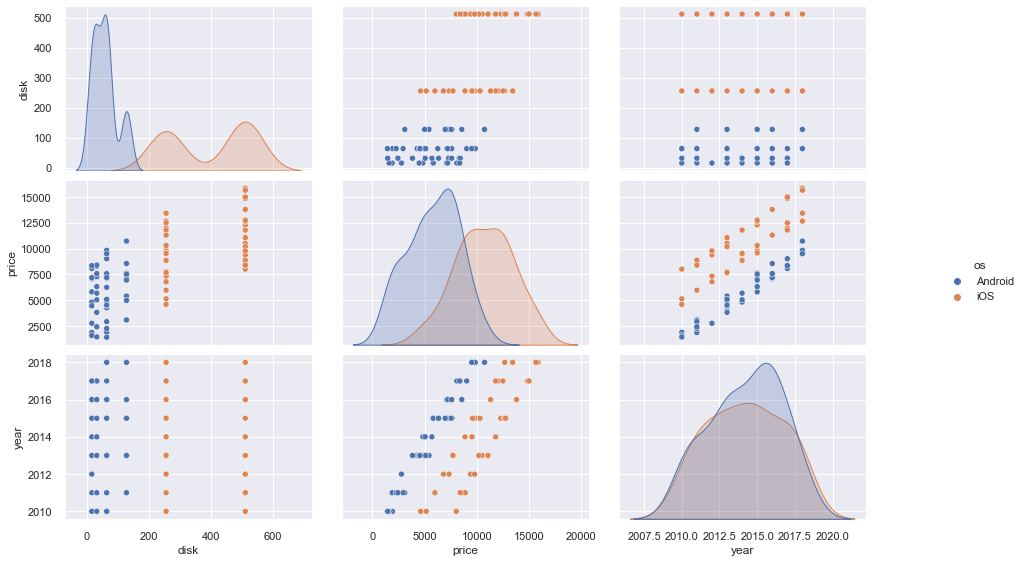

In [19]:
sns.set_theme(style="darkgrid")
sns.pairplot(df, hue="os")
plt.gcf().set_size_inches(15, 8)

Text(0.5, 1.0, 'График кривых Эндрюса - кластерный анализ моделей телефонов')

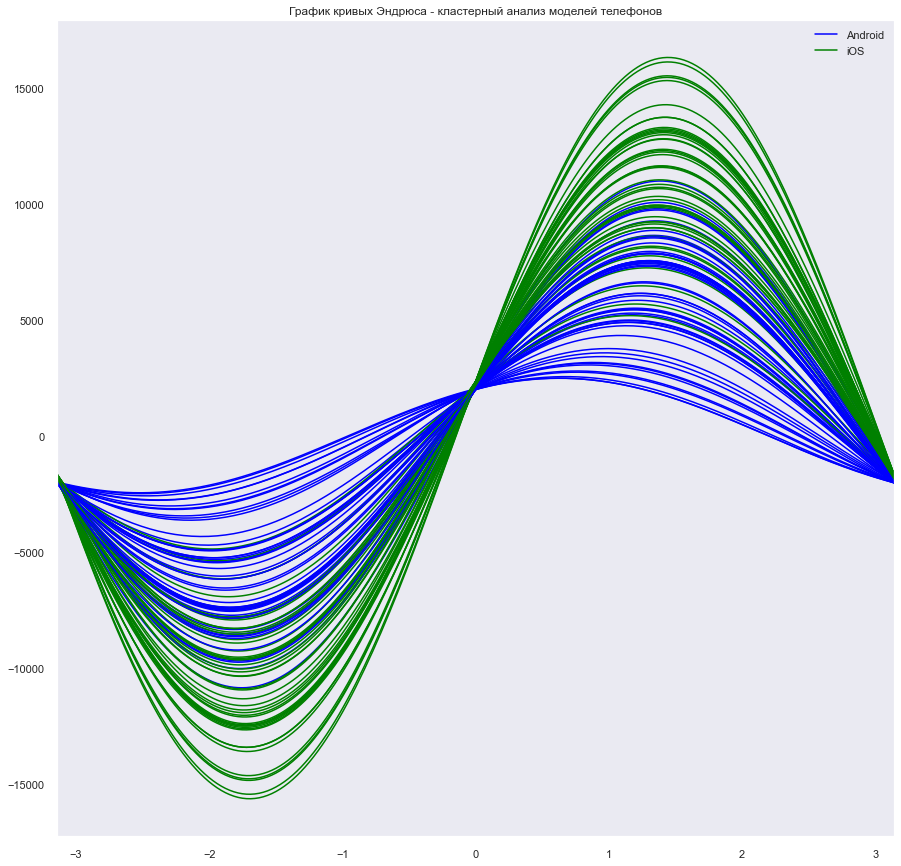

In [20]:
plt.figure(figsize=(15,15))
andrews_curves(df, 'os', color=['blue', 'green']);
plt.title('График кривых Эндрюса - кластерный анализ моделей телефонов')

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\misc.py:131: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  ax = plt.gca(xlim=[-1, 1], ylim=[-1, 1])


<AxesSubplot:>

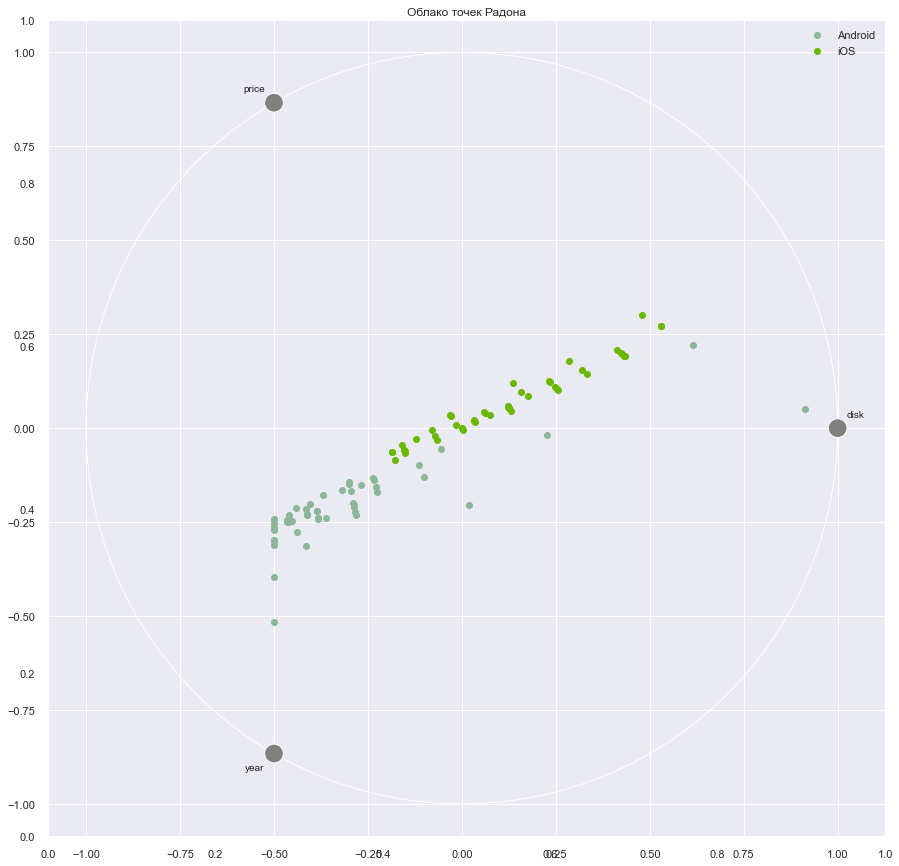

In [21]:
from pandas.plotting import radviz
plt.figure(figsize=(15,15))
plt.title('Облако точек Радона')
radviz(df, 'os')

Т.к. операционная система сама по себе является кластерной меткой - оставим в признаках размер диска, цену и год выпуска.

In [22]:
### Тут нужно выгрузить в соответствующие переменные выбранные признаки ###
X = df.drop('os', axis=1)

Воспользуемcя алгоритмом KMeans, попробуем предсказать два кластера.

In [23]:
### Здесь следует запустить процесс обучения ###
### и продемонстрировать работоспобность обученной модели ###
k_means = KMeans(init='random', n_clusters=2).fit(X)

In [24]:
df['Label'] = k_means.labels_.astype('str')

По графику видно, что модель хорошо определила кластеры нижней и верхней ценовой категории, правильно поместив андроиды вниз, а айфоны вверх. В центре модель захватила половину айфонов, отнеся их к андроидам, но при это видно, что ценовой кластер средней категории разделён ровно пополам.

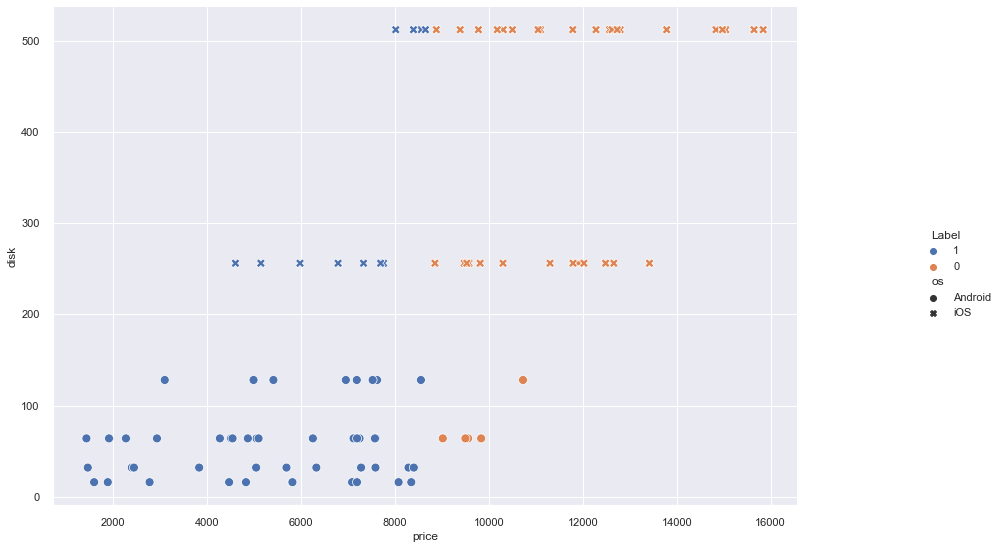

In [25]:
sns.relplot(x="price", y="disk", hue="Label", style="os", s=80, data=df)
plt.gcf().set_size_inches(15, 8)

Снизим размерность датасета для повторной попытки кластеризации. Распределение осталось примерно таким же.

In [26]:
pca = PCA(n_components=2).fit_transform(X)
k_means = KMeans(init='random', n_clusters=2).fit(pca)
pca = pd.DataFrame(pca, columns=['X1', 'X2'])
pca['Label'] = k_means.labels_.astype('str')
pca['os'] = df['os']

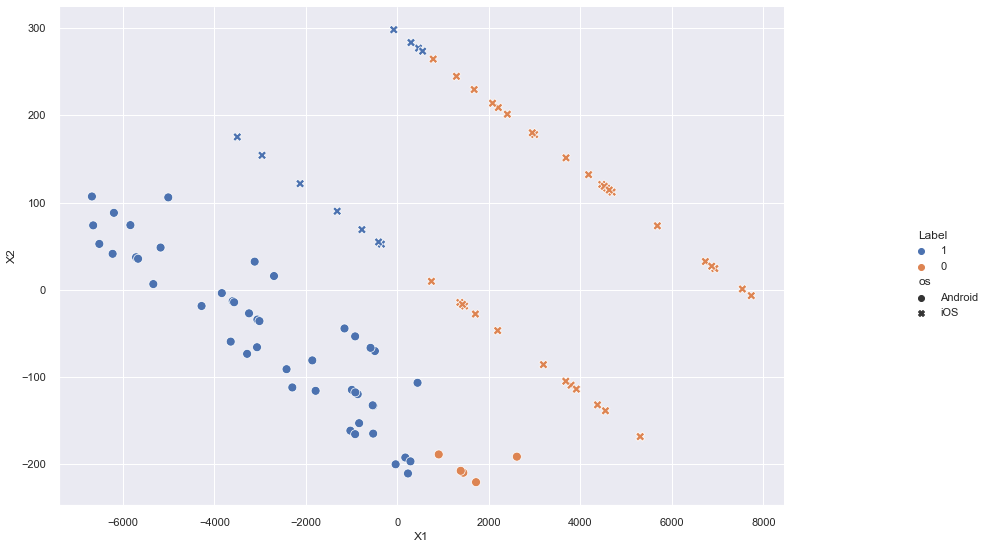

In [27]:
sns.relplot(x="X1", y="X2", hue="Label", style="os", s=80, data=pca)
plt.gcf().set_size_inches(15, 8)